In [1]:
from predict_winner import reshape_all
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = reshape_all()
data.sample(5)

,winner,totalDamageDealt_team1,teamKd_team1,accuracy_team1,rotationalPercent_team1,fbPerc_team1,mode,totalDamageDealt_team2,teamKd_team2,accuracy_team2,rotationalPercent_team2,fbPerc_team2
57,team1,12090.0,1.010000,0.301236,0.217822,0.000000,CDL Hardpoint,11915.0,0.990099,0.288724,0.260000,0.002024
328,team1,10096.0,1.135135,0.199179,0.202381,0.000000,CDL Hardpoint,9683.0,0.880952,0.271089,0.256757,0.002398
364,team1,10931.0,1.060976,0.271995,0.195402,0.002041,CDL Hardpoint,10520.0,0.942529,0.302548,0.231707,0.000000
389,team1,3473.0,1.526316,0.268692,0.000000,0.750000,CDL SnD,2580.0,0.655172,0.223558,0.000000,0.250000
396,team2,10893.0,1.000000,0.283071,0.179775,0.002146,CDL Hardpoint,11283.0,1.000000,0.276412,0.247191,0.000000


In [2]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

data['winner'] = label_encoder.fit_transform(data['winner'])
result_map = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
result_map

{'team1': 0, 'team2': 1}

In [3]:
snd = data[data['mode']=='CDL SnD'].copy()
hp = data[data['mode']=='CDL Hardpoint'].copy()
cl = data[data['mode']=='CDL Control'].copy()

snd.drop(columns=['rotationalPercent_team1', 'rotationalPercent_team2', 'mode'], axis=1, inplace=True)
hp.drop(columns=['fbPerc_team2', 'fbPerc_team1', 'mode'], axis=1, inplace=True)
cl.drop(columns=['fbPerc_team2', 'fbPerc_team1', 'rotationalPercent_team1', 'rotationalPercent_team2', 'mode'], axis=1, inplace=True)

snd.dropna(axis=0, how='any', inplace=True)
snd.drop(columns=['accuracy_team1', 'accuracy_team2'], axis=1, inplace=True)
hp.dropna(axis=0, how='any', inplace=True)
cl.dropna(axis=0, how='any', inplace=True)

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# HARPOINT MODEL
X = hp.drop('winner', axis=1)
y = hp['winner']

trainX, testX = train_test_split(X, test_size=0.8, random_state=4)
trainY, testY = train_test_split(y, test_size=0.8, random_state=4)

print(f"Train X Shape: {trainX.shape}, Test X Shape: {testX.shape}\nTrain Y Shape: {trainY.shape}, Test Y Shape: {testY.shape}")

Train X Shape: (37, 8), Test X Shape: (150, 8)
Train Y Shape: (37,), Test Y Shape: (150,)


In [5]:
rf = RandomForestClassifier()
rf.fit(trainX, trainY)
y_pred = rf.predict(testX)
accuracy = accuracy_score(testY, y_pred)
print(f"Initial Accuracy: {accuracy}")

Initial Accuracy: 0.7933333333333333


In [6]:
param_dist = {'n_estimators': randint(50, 500),
              'max_depth': randint(1,20)}

rf = RandomForestClassifier()

rand_search = RandomizedSearchCV(rf,
                                 param_distributions=param_dist,
                                 n_iter=50,
                                 cv=4)

rand_search.fit(trainX, trainY)

RandomizedSearchCV(cv=4, estimator=RandomForestClassifier(), n_iter=50,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f8d9e9a1dd8>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f8d9e9a1eb8>})

In [7]:
import re
hp_md, hp_esti = [int(i) for i in re.findall(string=str(rand_search.best_estimator_), pattern='[0-9]+')]
print(f"Max Depth: {hp_md}, n_estimator: {hp_esti}")



Max Depth: 11, n_estimator: 67


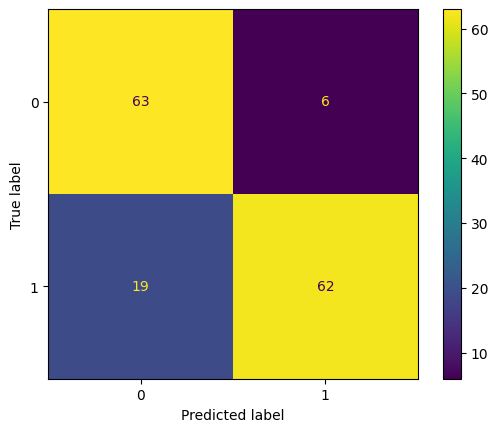

In [8]:
y_pred = rand_search.predict(testX)

cm = confusion_matrix(testY, y_pred)
ConfusionMatrixDisplay(cm).plot();

In [9]:
precision = precision_score(testY, y_pred)
accuracy = accuracy_score(testY, y_pred)
recall = recall_score(testY, y_pred)

print(f"Precision: {precision}\nAccuracy: {accuracy}\nRecall: {recall}")

Precision: 0.9117647058823529
Accuracy: 0.8333333333333334
Recall: 0.7654320987654321


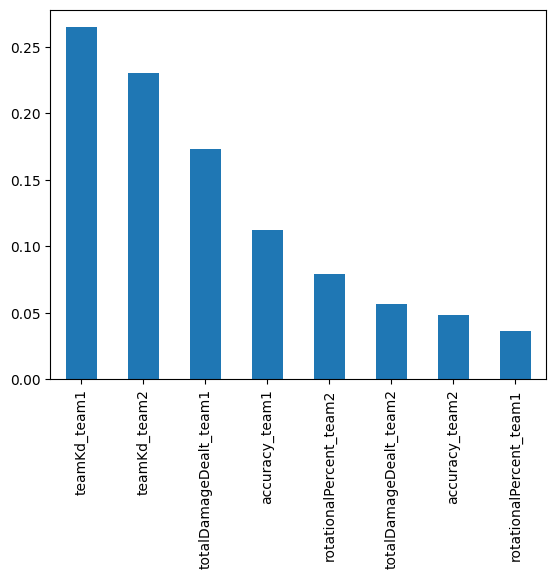

In [10]:
rf = RandomForestClassifier(max_depth=hp_md, n_estimators=hp_esti).fit(trainX, trainY)
feature_importances = pd.Series(rf.feature_importances_, index=trainX.columns).sort_values(ascending=False)

feature_importances.plot.bar();

In [11]:
y_pred = rf.predict(testX)

precision = precision_score(testY, y_pred).round(4)
accuracy = accuracy_score(testY, y_pred).round(4)
recall = recall_score(testY, y_pred).round(4)

print(f"Precision: {precision}\nAccuracy: {accuracy}\nRecall: {recall}")

Precision: 0.9219
Accuracy: 0.82
Recall: 0.7284


# Next, I will create a similar model for Search And Destroy

In [12]:
X = snd.drop('winner', axis=1)
y = snd['winner']

trainX, testX = train_test_split(X, test_size=0.8, random_state=4)
trainY, testY = train_test_split(y, test_size=0.8, random_state=4)

rf = RandomForestClassifier()
rf.fit(trainX, trainY)
y_pred = rf.predict(testX)
accuracy = accuracy_score(testY, y_pred)
print(f"Initial Accuracy: {accuracy}")

Initial Accuracy: 0.8706896551724138


In [13]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

rf = RandomForestClassifier()

rand_search = RandomizedSearchCV(rf,
                                 param_distributions=param_dist,
                                 n_iter=50,
                                 cv=4)

rand_search.fit(trainX, trainY)

RandomizedSearchCV(cv=4, estimator=RandomForestClassifier(), n_iter=50,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f8d9ee2e0b8>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f8d9ee1d9e8>})

In [14]:
snd_md, snd_esti = [int(i) for i in re.findall(string=str(rand_search.best_estimator_), pattern='[0-9]+')]
print(f"Max Depth: {snd_md}, n_estimator: {snd_esti}")


Max Depth: 4, n_estimator: 306


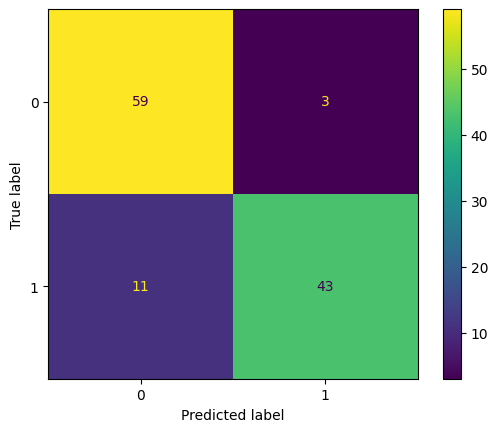

In [15]:
y_pred = rand_search.predict(testX)

cm = confusion_matrix(testY, y_pred)
ConfusionMatrixDisplay(cm).plot();

In [16]:
precision = precision_score(testY, y_pred)
accuracy = accuracy_score(testY, y_pred)
recall = recall_score(testY, y_pred)

print(f"Precision: {precision}\nAccuracy: {accuracy}\nRecall: {recall}")

Precision: 0.9347826086956522
Accuracy: 0.8793103448275862
Recall: 0.7962962962962963


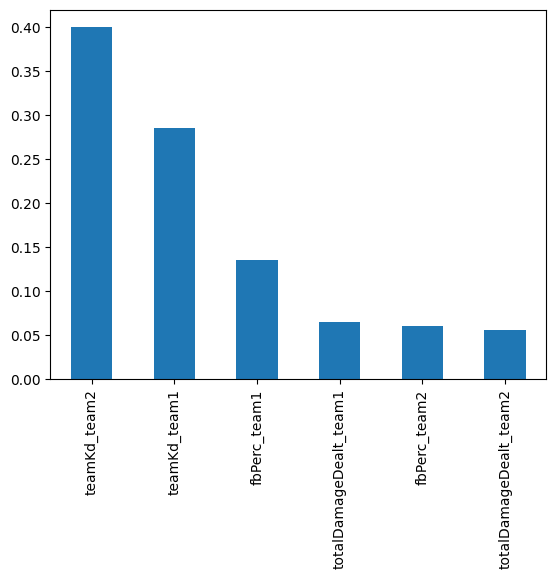

In [17]:
rf = RandomForestClassifier(max_depth=snd_md, n_estimators=snd_esti).fit(trainX, trainY)
feature_importances = pd.Series(rf.feature_importances_, index=trainX.columns).sort_values(ascending=False)

feature_importances.plot.bar();

In [18]:
y_pred = rf.predict(testX)

precision = precision_score(testY, y_pred).round(4)
accuracy = accuracy_score(testY, y_pred).round(4)
recall = recall_score(testY, y_pred).round(4)

print(f"Precision: {precision}\nAccuracy: {accuracy}\nRecall: {recall}")

Precision: 0.8936
Accuracy: 0.8534
Recall: 0.7778


# Finally, Control

In [19]:
X = cl.drop('winner', axis=1)
y = cl['winner']

trainX, testX = train_test_split(X, test_size=0.8, random_state=4)
trainY, testY = train_test_split(y, test_size=0.8, random_state=4)

rf = RandomForestClassifier()
rf.fit(trainX, trainY)
y_pred = rf.predict(testX)
accuracy = accuracy_score(testY, y_pred)
print(f"Initial Accuracy: {accuracy}")

Initial Accuracy: 0.8571428571428571


In [20]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

rf = RandomForestClassifier()

rand_search = RandomizedSearchCV(rf,
                                 param_distributions=param_dist,
                                 n_iter=150,
                                 cv=3)

rand_search.fit(trainX, trainY)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=150,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f8d9f0e5f28>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f8d998b3d30>})

In [21]:
cnt_md, cnt_esti = [int(i) for i in re.findall(string=str(rand_search.best_estimator_), pattern='[0-9]+')]
print(f"Max Depth: {cnt_md}, n_estimator: {cnt_esti}")


Max Depth: 17, n_estimator: 71


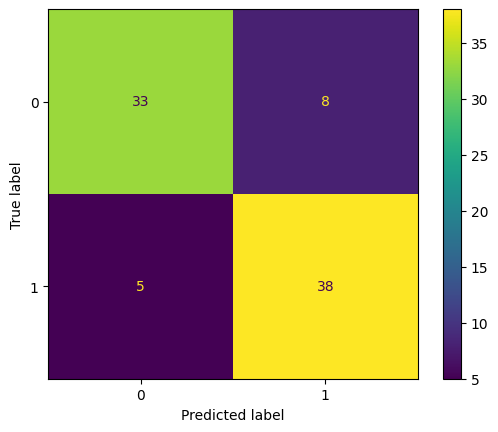

In [22]:
y_pred = rand_search.predict(testX)

cm = confusion_matrix(testY, y_pred)
ConfusionMatrixDisplay(cm).plot();

In [23]:
precision = precision_score(testY, y_pred)
accuracy = accuracy_score(testY, y_pred)
recall = recall_score(testY, y_pred)

print(f"Precision: {precision}\nAccuracy: {accuracy}\nRecall: {recall}")

Precision: 0.8260869565217391
Accuracy: 0.8452380952380952
Recall: 0.8837209302325582


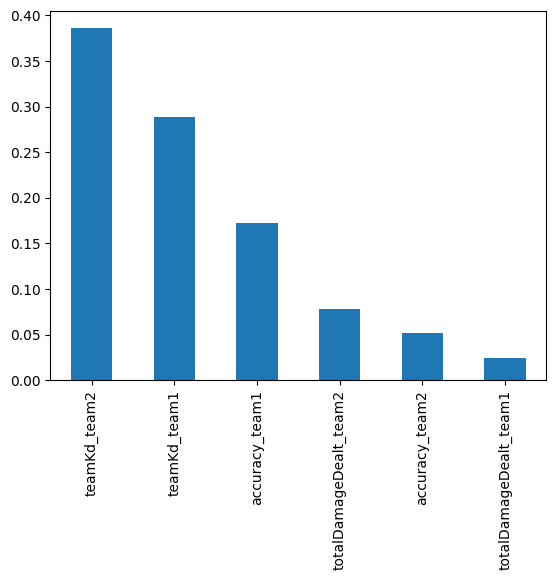

In [24]:
rf = RandomForestClassifier(max_depth=cnt_md, n_estimators=cnt_esti).fit(trainX, trainY)
feature_importances = pd.Series(rf.feature_importances_, index=trainX.columns).sort_values(ascending=False)

feature_importances.plot.bar();

In [25]:
y_pred = rf.predict(testX)

precision = precision_score(testY, y_pred).round(4)
accuracy = accuracy_score(testY, y_pred).round(4)
recall = recall_score(testY, y_pred).round(4)

print(f"Precision: {precision}\nAccuracy: {accuracy}\nRecall: {recall}")

Precision: 0.8444
Accuracy: 0.8571
Recall: 0.8837
